In [104]:
#Zona de importe primeras librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [105]:
# Cargamos los datos
# Cargar el archivo CSV
data = pd.read_csv('data_prepared.csv')
pd.set_option('display.float_format', '{:.6f}'.format)

In [106]:
data.head()

,Unnamed: 0,Bill Amt,Purch Amt,ROI,Account Name_Ace Law Group,Account Name_Adamson Ahdoot LLP,Account Name_Agwara Law,Account Name_Allen Injury Law LLC,Account Name_Angulo Law Group,Account Name_Atkinson Watkins & Hoffman Attorneys,...,Subject_Chiropractic,Subject_Evaluation,Subject_Imaging,Subject_Lien,Subject_Medical Device,Subject_Neurology,Subject_Orthopedics,Subject_Pain Management,Subject_Physical Therapy,Subject_Surgery
0,0,0.000178,0.005597,0.964286,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0.000178,0.005597,1.035714,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2,0.000178,0.005597,1.142857,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0.000178,0.005597,0.785714,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,5,0.000178,0.006003,1.000000,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [107]:
data = data.drop(columns=['Unnamed: 0'])

<Axes: >

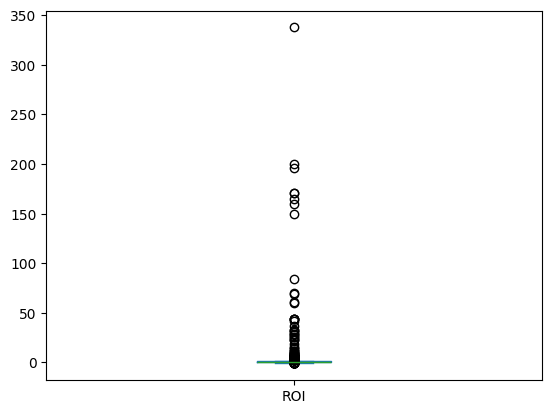

In [108]:
#División 70-30 para validación cruzada
X = data.drop("ROI", axis=1)
Y = data['ROI']

# División estratégica: 70% para entrenamiento (con CV) y 30% para prueba final
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)
Y_train.plot(kind='box')

### ***Validación Cruzada***

In [109]:
# Configuración de K-Fold con 10 particiones
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# DataFrame para almacenar resultados de validación cruzada
resultados_cv = pd.DataFrame()

# DataFrame para almacenar resultados en conjunto de prueba
medidas_prueba = pd.DataFrame(index=['mse', 'rmse', 'mae', 'mape', 'r2', 'max_error'])


In [110]:
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=10,
    min_samples_leaf=20,
    min_samples_split=50,
    random_state=42
)

# Validación cruzada
scores_cv = cross_val_score(
    model_dt, X_train, Y_train,
    cv=kfold,
    scoring='neg_mean_squared_error'
)
resultados_cv['Arbol_DT'] = -scores_cv

# Entrenamiento con el conjunto completo de entrenamiento
model_dt.fit(X_train, Y_train)

# Evaluación en conjunto de prueba
Y_pred = model_dt.predict(X_test)

mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(Y_test, Y_pred)
mape = metrics.mean_absolute_percentage_error(Y_test, Y_pred)
r2 = metrics.r2_score(Y_test, Y_pred)
max_error = metrics.max_error(Y_test, Y_pred)

medidas_prueba['Arbol_DT'] = [mse, rmse, mae, mape, r2, max_error]
medidas_prueba

,Arbol_DT
mse,175.828224
rmse,13.260024
mae,4.765048
mape,146163192261350.343750
r2,-0.227025
max_error,114.238743


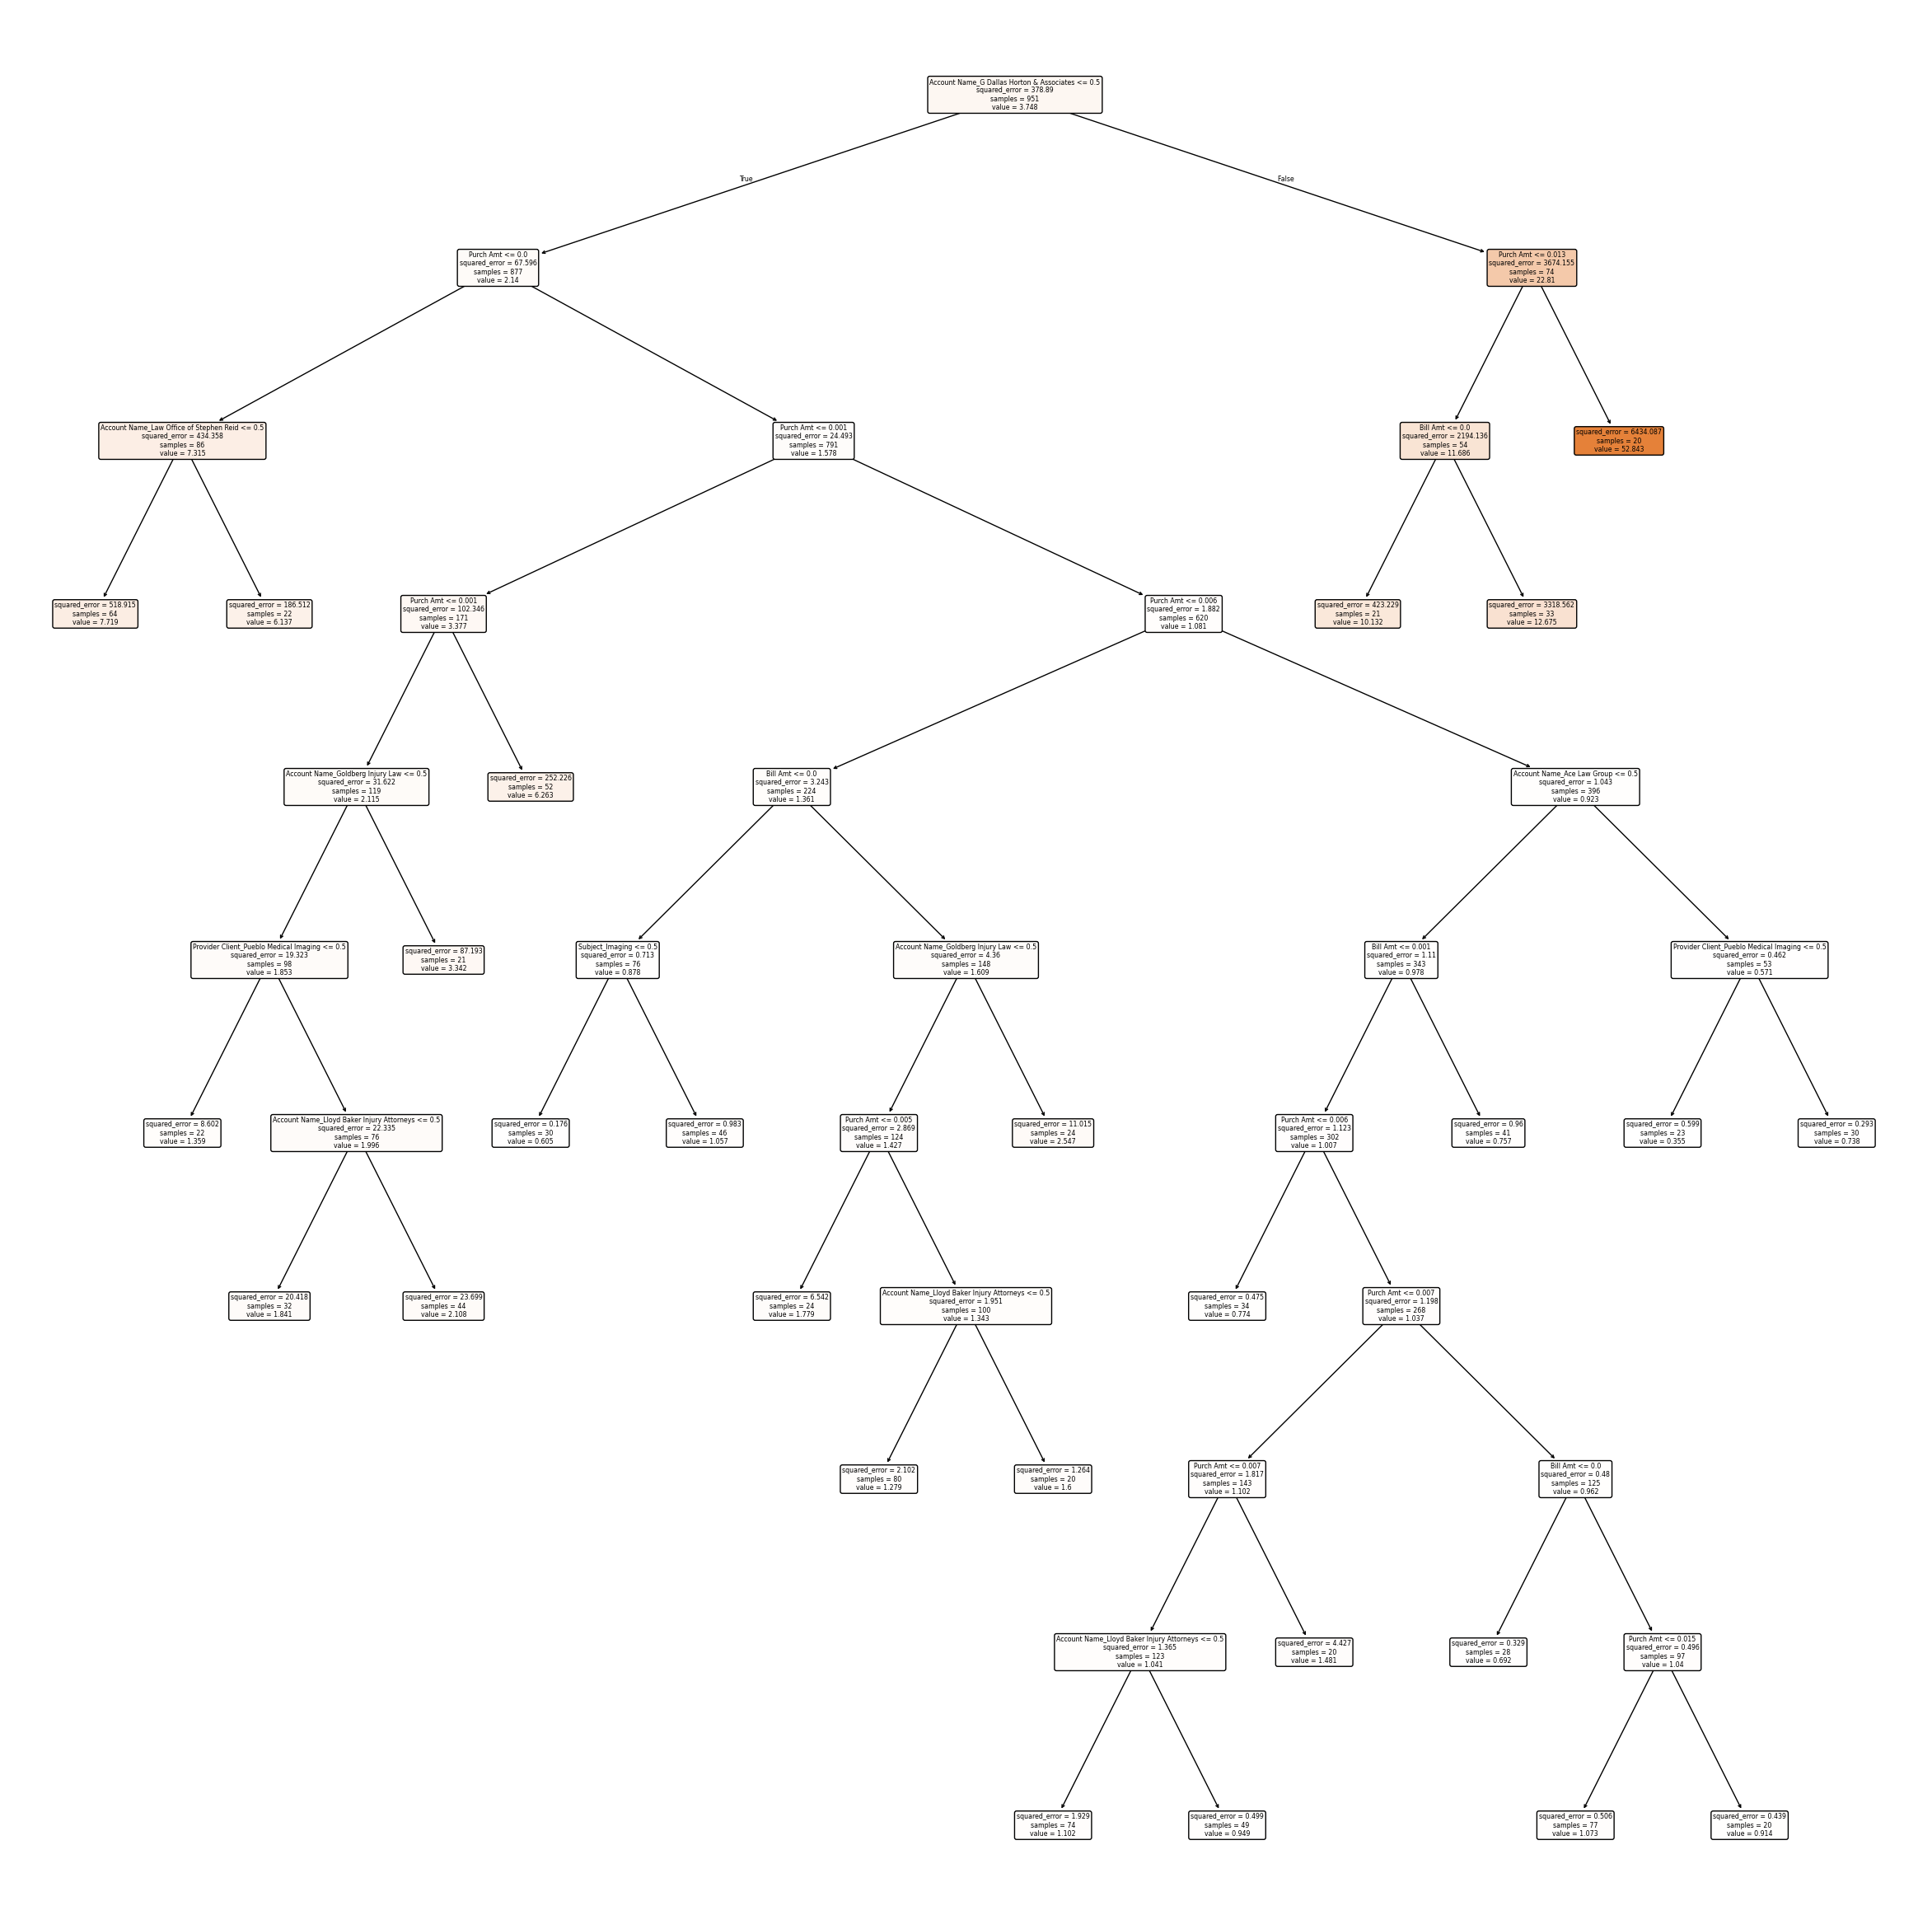

In [111]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30,30))
plot_tree(model_dt, feature_names=X_train.columns.values,  rounded=True, filled=True)
plt.show()

In [112]:
from sklearn.neighbors import KNeighborsRegressor

model_knn = KNeighborsRegressor(
    n_neighbors=5,
    metric='euclidean',
    weights='distance'
)

# Validación cruzada con datos escalados
scores_cv = cross_val_score(
    model_knn, X_train, Y_train,
    cv=kfold,
    scoring='neg_mean_squared_error'
)
resultados_cv['KNN'] = -scores_cv

# Entrenamiento
model_knn.fit(X_train, Y_train)

# Evaluación en conjunto de prueba
Y_pred = model_knn.predict(X_test)

mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(Y_test, Y_pred)
mape = metrics.mean_absolute_percentage_error(Y_test, Y_pred)
r2 = metrics.r2_score(Y_test, Y_pred)
max_error = metrics.max_error(Y_test, Y_pred)

medidas_prueba['KNN'] = [mse, rmse, mae, mape, r2, max_error]
medidas_prueba

,Arbol_DT,KNN
mse,175.828224,270.400170
rmse,13.260024,16.443849
mae,4.765048,4.285399
mape,146163192261350.343750,119676817425079.875000
r2,-0.227025,-0.886999
max_error,114.238743,181.925130


In [113]:
from sklearn.neural_network import MLPRegressor

model_nn = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    verbose=False,
    early_stopping=True
)

# Validación cruzada con datos escalados
scores_cv = cross_val_score(
    model_nn, X_train, Y_train,
    cv=kfold,
    scoring='neg_mean_squared_error'
)
resultados_cv['Red_Neuronal'] = -scores_cv

# Entrenamiento
model_nn.fit(X_train, Y_train)

# Evaluación en conjunto de prueba
Y_pred = model_nn.predict(X_test)

mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(Y_test, Y_pred)
mape = metrics.mean_absolute_percentage_error(Y_test, Y_pred)
r2 = metrics.r2_score(Y_test, Y_pred)
max_error = metrics.max_error(Y_test, Y_pred)

medidas_prueba['Red_Neuronal'] = [mse, rmse, mae, mape, r2, max_error]
medidas_prueba

,Arbol_DT,KNN,Red_Neuronal
mse,175.828224,270.400170,134.887184
rmse,13.260024,16.443849,11.614094
mae,4.765048,4.285399,4.000323
mape,146163192261350.343750,119676817425079.875000,112657735333852.687500
r2,-0.227025,-0.886999,0.058684
max_error,114.238743,181.925130,148.539576


In [114]:
from sklearn.svm import SVR

model_svm = SVR(
    kernel='rbf',
    C=1.0,
    epsilon=0.1,
    gamma='scale'
)

# Validación cruzada con datos escalados
scores_cv = cross_val_score(
    model_svm, X_train, Y_train,
    cv=kfold,
    scoring='neg_mean_squared_error'
)
resultados_cv['SVM'] = -scores_cv

# Entrenamiento
model_svm.fit(X_train, Y_train)

# Evaluación en conjunto de prueba
Y_pred = model_svm.predict(X_test)

mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(Y_test, Y_pred)
mape = metrics.mean_absolute_percentage_error(Y_test, Y_pred)
r2 = metrics.r2_score(Y_test, Y_pred)
max_error = metrics.max_error(Y_test, Y_pred)

medidas_prueba['SVM'] = [mse, rmse, mae, mape, r2, max_error]
medidas_prueba

,Arbol_DT,KNN,Red_Neuronal,SVM
mse,175.828224,270.400170,134.887184,146.641826
rmse,13.260024,16.443849,11.614094,12.109576
mae,4.765048,4.285399,4.000323,2.433852
mape,146163192261350.343750,119676817425079.875000,112657735333852.687500,32055781955867.097656
r2,-0.227025,-0.886999,0.058684,-0.023346
max_error,114.238743,181.925130,148.539576,158.036654
